In [1]:
import math
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn


import torchvision
import torchvision.transforms as transforms

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt


# Data Loader

In [2]:
from torch.utils.data import Dataset
NUM_WORKERS = 4

In [272]:
def get_cifar(num_classes=10, dataset_dir="./data", batch_size=1,
              use_cifar_10_1=False):

    if num_classes == 10:
        print("Loading CIFAR10...")
        dataset = torchvision.datasets.CIFAR10
        normalize = transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    else:
        print("Loading CIFAR100...")
        dataset = torchvision.datasets.CIFAR100
        normalize = transforms.Normalize(
            mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

    train_transform = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    trainset = dataset(root=dataset_dir, train=True,
                       download=True, transform=train_transform)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # Use the normal cifar 10 testset or a new one to test true generalization
    if use_cifar_10_1 and num_classes == 10:
        imagedata, labels = load_cifar_10_1()
        testset = TensorImgSet((imagedata, labels), transform=test_transform)
    else:
        testset = dataset(root=dataset_dir, train=False,
                          download=True,
                          transform=test_transform)

    train_loader = torch.utils.data.DataLoader(trainset,
                                               batch_size=batch_size,
                                               num_workers=NUM_WORKERS,
                                               pin_memory=True, shuffle=False)
    test_loader = torch.utils.data.DataLoader(testset,
                                              batch_size=batch_size,
                                              num_workers=NUM_WORKERS,
                                              pin_memory=True, shuffle=False)
    return train_loader, test_loader

In [318]:
train_loader, test_loader=get_cifar(10)

Loading CIFAR10...
Files already downloaded and verified
Files already downloaded and verified


In [160]:
from models.model_factory import create_model
import util
from evaluate import * 
    
device = util.setup_torch()

    


Using cpu to train.


# Plot

In [6]:
def plot_timage(img):
    '''
    img: 输入Tensor[3xWxH],经过normalize图像
    '''
    inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010])
    if len(img.shape)==4:
        img=img[0]
    img = inv_normalize(img)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.show()

def plot_mask(mask):
    '''纯 WxH mask
    '''
    if len(mask.shape)==4:
        mask=mask[0,0]
    elif len(mask.shape)==3:
        mask=mask[0]
    plt.imshow(mask,cmap='YlGnBu')
    plt.show()

In [31]:
x,y=iter(train_loader).next()
print(x.shape,y.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


In [8]:
# plot_timage(x[0])

In [8]:

normalize = transforms.Normalize(
            mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])


In [353]:
x=torch.rand(2,2,3,3)
x

tensor([[[[0.0376, 0.4057, 0.4948],
          [0.0465, 0.7875, 0.5543],
          [0.4054, 0.6110, 0.5863]],

         [[0.1827, 0.3772, 0.5144],
          [0.0430, 0.1968, 0.7567],
          [0.8356, 0.8435, 0.8163]]],


        [[[0.3831, 0.9925, 0.2196],
          [0.8047, 0.1723, 0.5383],
          [0.6773, 0.1646, 0.9079]],

         [[0.0174, 0.2027, 0.8018],
          [0.8462, 0.6066, 0.3698],
          [0.4590, 0.7226, 0.2852]]]])

In [355]:
x[:,1]

tensor([[[0.1827, 0.3772, 0.5144],
         [0.0430, 0.1968, 0.7567],
         [0.8356, 0.8435, 0.8163]],

        [[0.0174, 0.2027, 0.8018],
         [0.8462, 0.6066, 0.3698],
         [0.4590, 0.7226, 0.2852]]])

# Teacher Model

In [317]:
params = {
"epochs": 1,
"modes": 'kd',
"t_checkpoint": 'pretrained/resnet20_cifar10.pth',
"results_dir": Path('results'),
"train_loader": train_loader,
"test_loader": test_loader,
"batch_size": 128,
# model configuration
"device": device,
"teacher_name": 'resnet18',
"student_name": 'resnet8',
"num_classes": 10,
# hyperparameters
"weight_decay": 5e-4,
"learning_rate": 0.1,
"momentum": 0.9,
"sched": 'multisteplr',
"optim": 'sgd',
# fixed knowledge distillation parameters
"lambda_student": 0.5,
"T_student": 5,
"augtype": None
}

t_net, best_teacher, best_t_acc=setup_teacher('resnet20', params)
t_net.eval()

Building model resnet20... total parameters: 283754, layers 67
Using 0 GPU(s).
---------- Loading Teacher -------
Decreasing learning rates at epoch 0 0 


DataParallel(
  (module): ResNetSmall(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [327]:
i=0
# Y18=[None]*10
# Y26=[None]*10
Y20=[None]*10

for x, y in train_loader:
    i+=1    
    pred=torch.nn.Softmax(dim=1)(t_net(x))
#     if Y26[y]==None:
#         Y26[y]=[]
#         Y26[y].append(pred)
#     else:
#         Y26[y].append(pred)
#     if Y18[y]==None:
#         Y18[y]=[]
#         Y18[y].append(pred)
#     else:
#         Y18[y].append(pred)
    if Y20[y]==None:
        Y20[y]=[]
        Y20[y].append(pred)
    else:
        Y20[y].append(pred)

    if i>5000:
        break




# for i in range(0,10):
#     Y26[i]=torch.cat(Y26[i])
# torch.save(Y26,'Y26')


# for i in range(0,10):
#     Y18[i]=torch.cat(Y18[i])
# torch.save(Y18,'Y18')

for i in range(0,10):
    Y20[i]=torch.cat(Y20[i])
torch.save(Y20,'Y20')


    

In [312]:
Y18=torch.load('Y18')
Y26=torch.load('Y26')


In [328]:
Y20=torch.load('Y20')


In [321]:
print(Y26[0].shape,Y18[0].shape,Y20[0].shape)

torch.Size([505, 10]) torch.Size([505, 10]) torch.Size([505, 10])


torch.Size([505, 10])

tensor([0.04924, 0.00859, 0.01086, 0.00942, 0.00763, 0.00838, 0.00783, 0.00835,
        0.01188, 0.01103], grad_fn=<StdBackward1>)
tensor([0.00754, 0.04236, 0.00759, 0.00773, 0.00684, 0.00823, 0.00835, 0.00743,
        0.00990, 0.01030], grad_fn=<StdBackward1>)
tensor([0.01008, 0.00579, 0.04265, 0.00907, 0.01034, 0.01000, 0.00998, 0.00843,
        0.00816, 0.00716], grad_fn=<StdBackward1>)
tensor([0.00781, 0.00792, 0.00902, 0.05081, 0.00936, 0.01299, 0.01028, 0.00917,
        0.00856, 0.00903], grad_fn=<StdBackward1>)
tensor([0.00848, 0.00634, 0.01059, 0.01016, 0.04494, 0.01046, 0.00924, 0.00933,
        0.00805, 0.00765], grad_fn=<StdBackward1>)
tensor([0.00757, 0.00635, 0.01107, 0.01110, 0.01101, 0.05085, 0.00809, 0.01057,
        0.00798, 0.00764], grad_fn=<StdBackward1>)
tensor([0.00717, 0.00768, 0.01188, 0.01048, 0.00964, 0.00859, 0.04615, 0.00833,
        0.00841, 0.00728], grad_fn=<StdBackward1>)
tensor([0.00822, 0.00672, 0.00825, 0.00902, 0.00981, 0.00943, 0.00620, 0.04187,
   

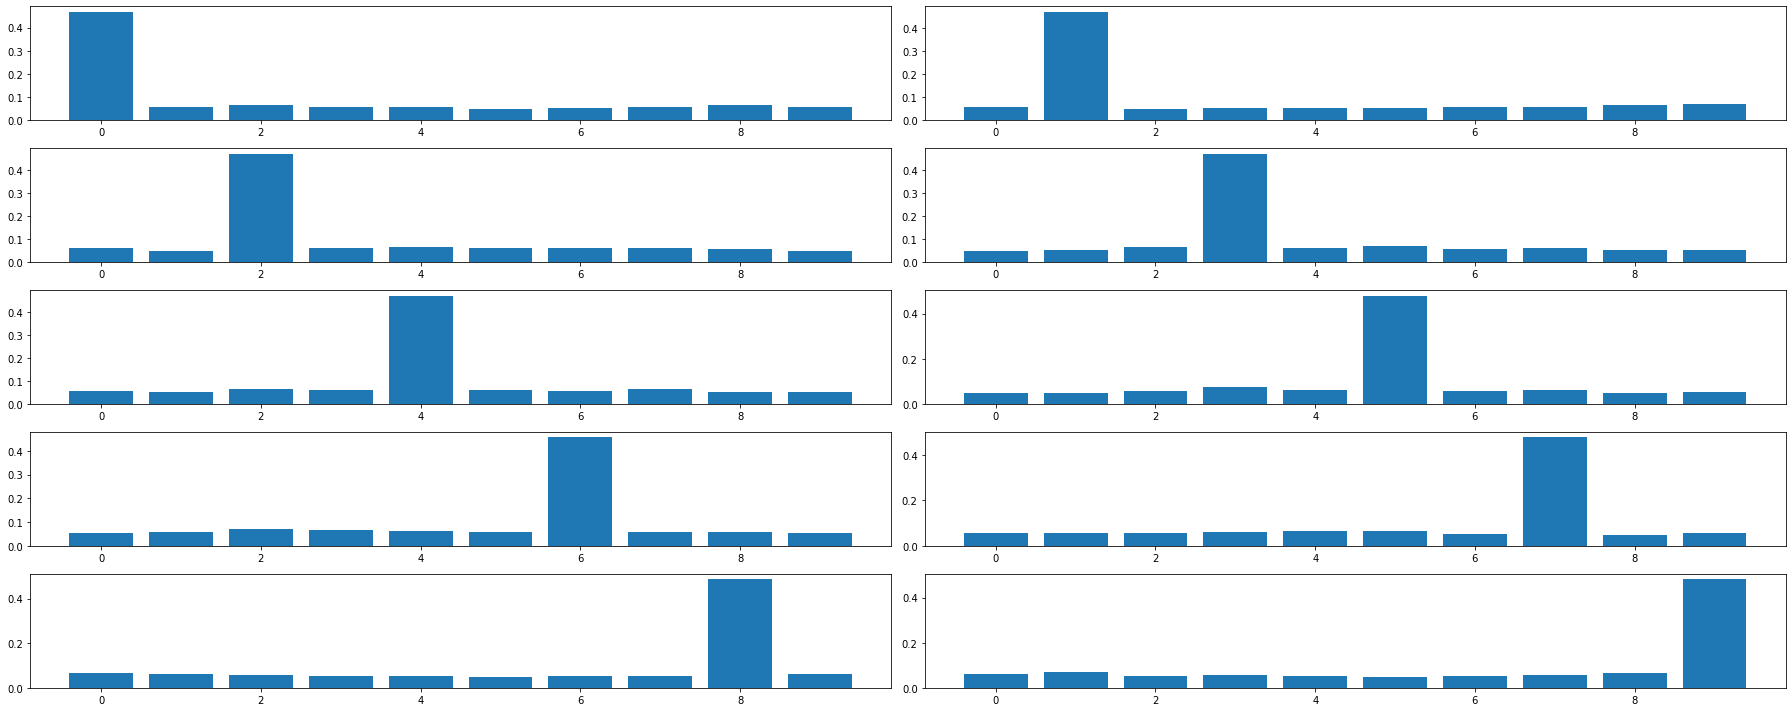

In [326]:
figure = plt.figure(figsize=(25, 10))
a=range(0,10)
for i in range(1,11):
    ax = plt.subplot(5, 2, i)
    plt.bar(a,Y18[i-1].detach().mean(dim=0))
    print(Y18[i-1].std(dim=0))
plt.tight_layout()
plt.show()

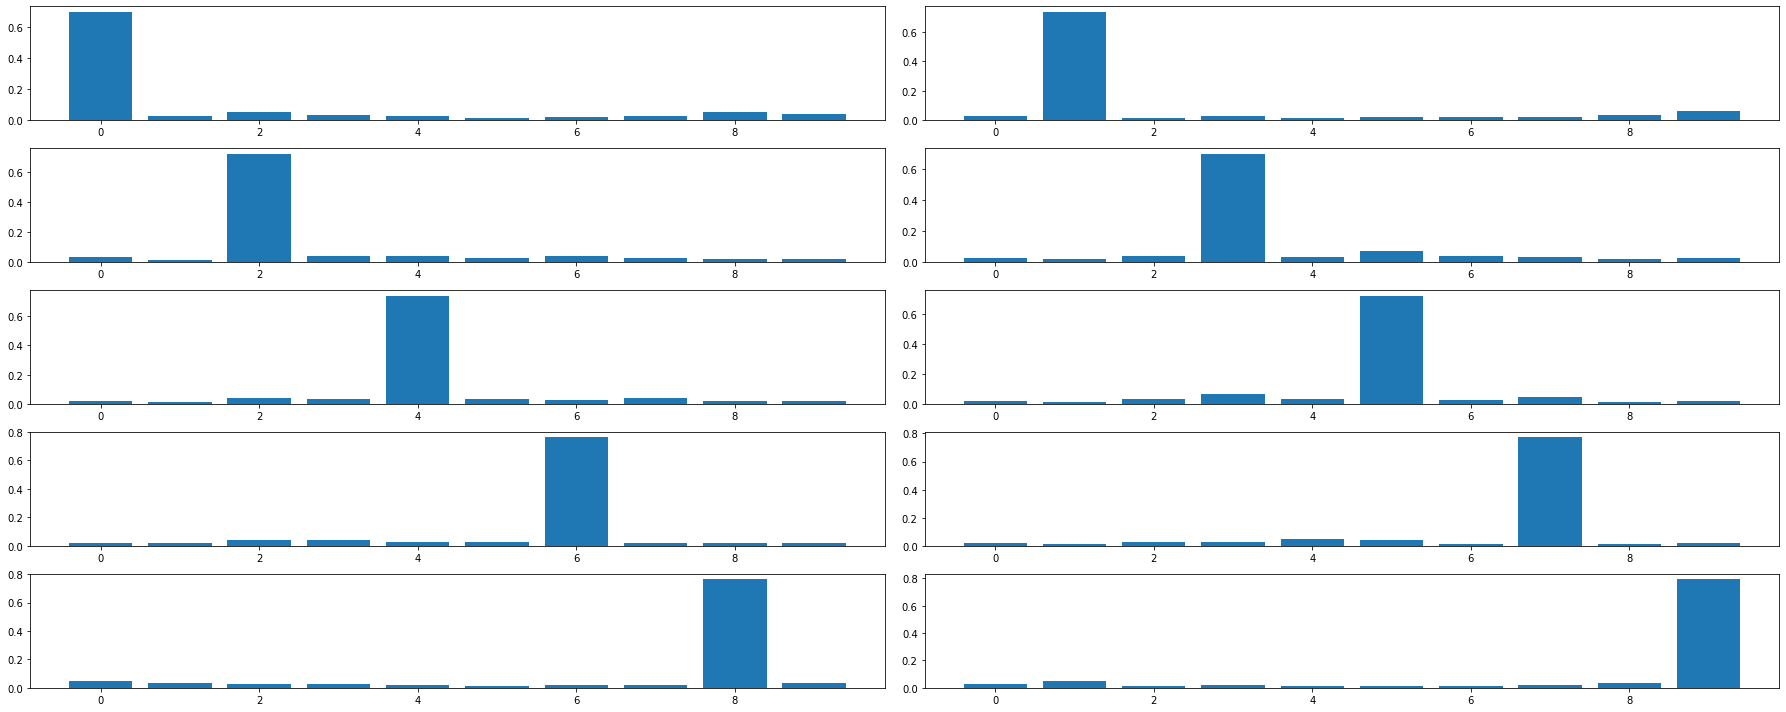

In [329]:
figure = plt.figure(figsize=(25, 10))
a=range(0,10)
for i in range(1,11):
    ax = plt.subplot(5, 2, i)
    plt.bar(a,Y26[i-1].detach().mean(dim=0))
plt.tight_layout()
plt.show()

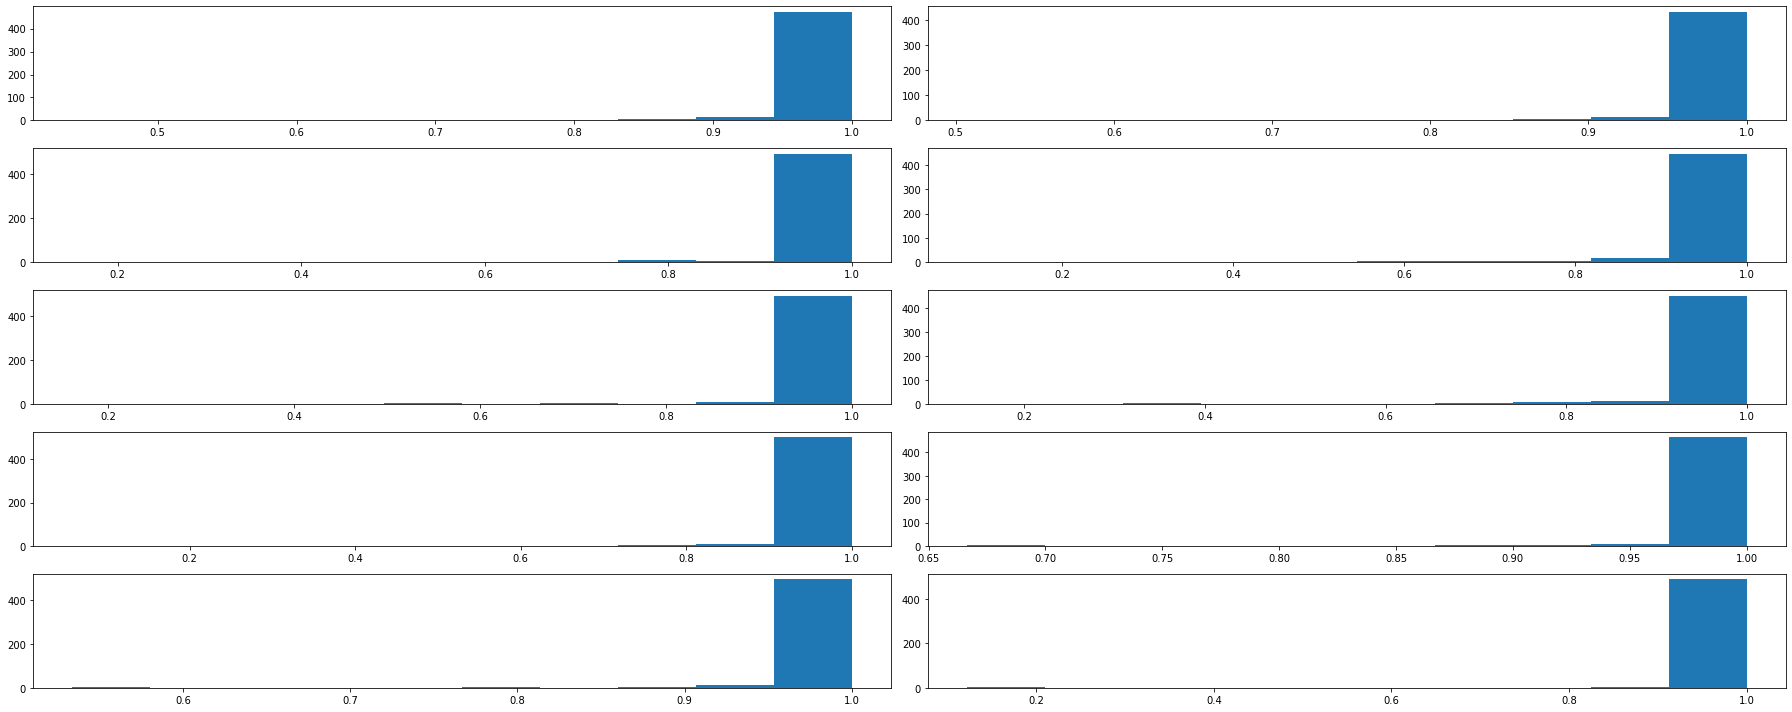

In [335]:
figure = plt.figure(figsize=(25, 10))
a=range(0,10)
for i in range(1,11):
    ax = plt.subplot(5, 2, i)
#     plt.bar(a,Y20[i-1].detach().mean(dim=0))
    plt.hist(Y20[i-1].detach()[:,i-1])
plt.tight_layout()
plt.show()

tensor([[9.99994e-01, 1.19779e-06, 2.44535e-07, 6.97980e-10, 1.13819e-11,
         1.12185e-10, 4.11237e-06, 1.60404e-08, 9.47121e-08, 6.77162e-08],
        [9.99999e-01, 2.16184e-08, 1.22297e-07, 6.83505e-10, 1.17196e-06,
         1.90095e-10, 1.20849e-09, 1.49768e-08, 2.79377e-08, 2.69534e-08],
        [9.99996e-01, 5.34097e-08, 3.07141e-08, 4.85914e-08, 9.52073e-11,
         1.73645e-08, 2.68665e-08, 1.28868e-07, 1.23885e-08, 3.66891e-06],
        [9.77327e-01, 8.10817e-08, 4.95853e-06, 2.18295e-02, 1.25011e-06,
         8.21311e-04, 5.89954e-07, 1.47023e-05, 1.81467e-07, 1.48516e-07],
        [9.99984e-01, 8.39965e-08, 1.80023e-10, 1.80202e-11, 1.29703e-10,
         1.11368e-12, 2.98587e-13, 2.54844e-10, 9.64038e-06, 6.04756e-06],
        [1.00000e+00, 1.01358e-08, 4.00752e-08, 6.89913e-08, 5.64716e-10,
         1.72390e-10, 3.00451e-10, 1.54082e-10, 2.37545e-07, 1.29807e-07],
        [9.99573e-01, 3.15407e-07, 3.94902e-04, 1.03030e-06, 4.76638e-07,
         1.94313e-07, 1.84581e-0

# GradCam

In [15]:
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.gradient import gradient
import cv2


upsample = torch.nn.Upsample(size=(32, 32))
upsample = torch.nn.UpsamplingBilinear2d(size=(32,32))
torch.set_printoptions(edgeitems=32)
mp = nn.AvgPool2d(4, stride=1,padding=0)#default=8
ap = nn.MaxPool2d(4, stride=1,padding=2)#default=8

In [16]:
# # print(saliency_grad[0,0])
# def hook(module, input, output):
#     outputs.append(output)
normalize = transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
back=normalize(torch.zeros(3,32,32))
# plot_timage(b)
back.expand(10,3,32,32).shape

def blur(img,kernel_size,sigma):
    if len(img.shape)==4:
        img=img[0]
    img=np.transpose(img, (1,2,0))
    blurred_img = torch.tensor(cv2.GaussianBlur(img.numpy(), (kernel_size, kernel_size), sigma))
    return np.transpose(blurred_img, (2,0,1))

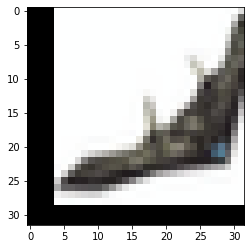

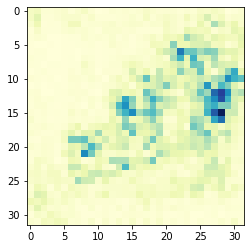

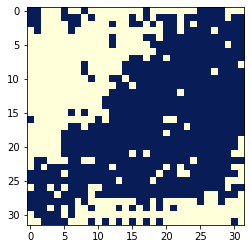

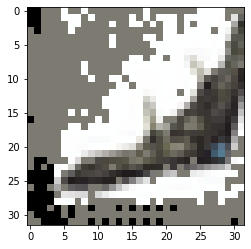

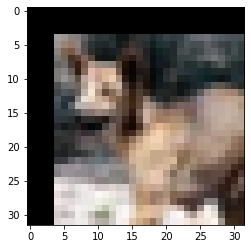

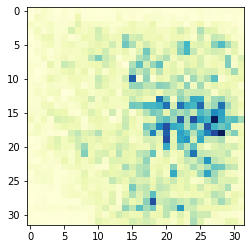

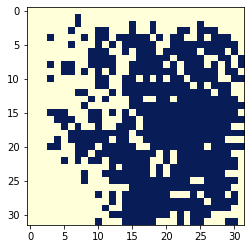

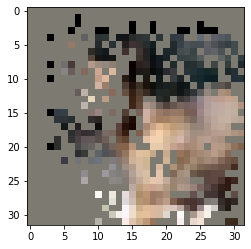

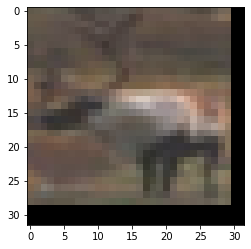

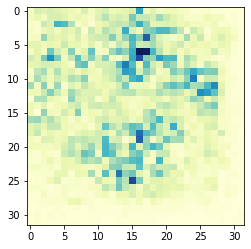

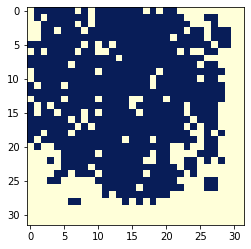

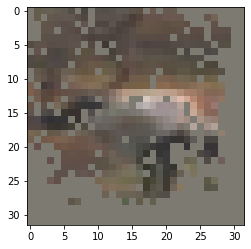

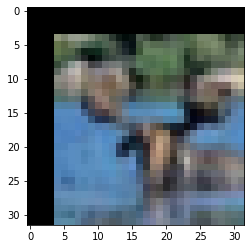

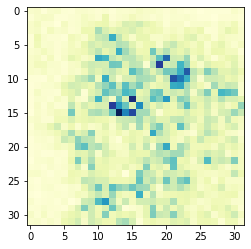

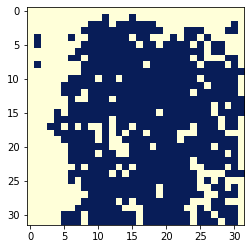

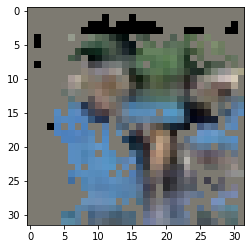

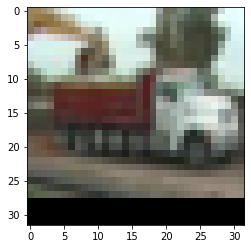

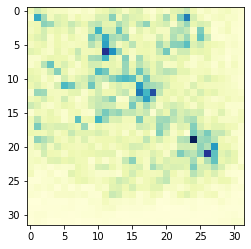

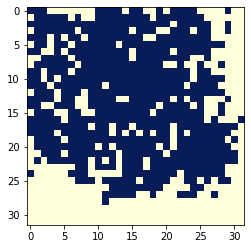

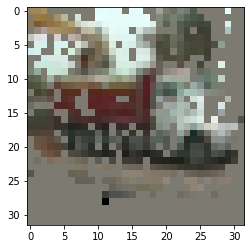

In [17]:
s=0
for i in range(s,s+5):
    plot_timage(x[i])
#     saliency = grad_cam(t_net, x[i:i+1], y[i], saliency_layer='module.layer3.1.conv2')
    saliency = gradient(t_net, x[i:i+1], y[i:i+1])
#     print(saliency)
#     saliency=mp(saliency)
#     saliency=mp(saliency)
#     saliency=mp(saliency)
    saliency=upsample(saliency.detach())
    plot_mask(saliency[0,0])
    
#     plot_timage(x[i]+noise)
    
    th=saliency.view(-1).sort()[0][int(32*32*torch.randint(4,6,(1,))*0.1)]
    mask=(saliency>th).float()
    plot_mask(mask)
#     
    noise=(0.04**0.5)*torch.randn(x[i:i+1].shape)
    mimage=x[i:i+1]*mask+(1-mask)*torch.zeros(1,3,32,32)
    plot_timage(mimage)

In [162]:
x,y=iter(train_loader).next()


In [172]:
torch.save(z,f='x.txt',)

In [173]:
z=torch.load(f='x.txt')

In [174]:
z.shape

torch.Size([128, 10])

In [26]:
from numpy.random import beta

In [150]:


def one_hot(x, n_class, dtype=torch.float32): 
    # X shape: (batch), output shape: (batch, n_class)
    x = x.long()
    res = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)
    res.scatter_(1, x.view(-1, 1), 1)
    return res

def rand_bbox(size, lam):
	W = size[2]
	H = size[3]
	cut_rat = np.sqrt(1. - lam)
	cut_w = np.int(W * cut_rat)
	cut_h = np.int(H * cut_rat)

	# uniform
	cx = np.random.randint(W)
	cy = np.random.randint(H)

	bbx1 = np.clip(cx - cut_w // 2, 0, W)
	bby1 = np.clip(cy - cut_h // 2, 0, H)
	bbx2 = np.clip(cx + cut_w // 2, 0, W)
	bby2 = np.clip(cy + cut_h // 2, 0, H)

	return bbx1, bby1, bbx2, bby2
def augdata(input, target):
    target=one_hot(target,10)
    lam= beta(0.2,  0.2)
    rand_index = torch.randperm(input.size(0))
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    lam_t = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
    inputx=input.clone()
    inputx[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
    return inputx, target_a*lam_t+target_b * (1. - lam_t)

def augdatax(input, target):
    target=one_hot(target,10)
    lam= beta(0.2,  0.2)
    rand_index = torch.randperm(input.size(0))
    
  
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    inputx=input.clone()
    inputx[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]

    n_sample=input.size(0)
    saliency = gradient(t_net, input, target)
    smax=saliency.view( n_sample,-1).sum(dim=1)
    mask=torch.ones(saliency.shape)
    mask[:,:,bbx1:bbx2, bby1:bby2]=0
    sa=(saliency*mask).view(n_sample,-1).sum(dim=1)/smax
    
    sb=saliency[rand_index, :, bbx1:bbx2, bby1:bby2].view( n_sample,-1).sum(dim=1)/smax[rand_index]
    lam_t=sa/(sa+sb)
    print(sa,sb,lam_t)
    print(target_a)
    print(target_b)
    lam_t=(lam_t.unsqueeze(1)).expand(n_sample,10)
    print(target_a*lam_t+target_b * (1. - lam_t))
    return inputx, target_a*lam_t+target_b * (1. - lam_t)



In [144]:
l1=torch.rand(5)
# l1=l1.expand(5,10)
# l2=torch.rand(5,10)
# l1*l2
l1.unsqueeze(1).shape

torch.Size([5, 1])

In [154]:
i=0
X=x[i:i+10]
Y=y[i:i+10]
# saliency = gradient(t_net, X, Y)





In [70]:
smax

tensor([119.4203,  84.5336, 246.7126, 183.8685,  97.8528,  40.3200, 104.4852,
         82.9226, 180.6544,  34.3183])

In [156]:
ag, agy=augdatax(X, Y)

tensor([0.1516, 0.1523, 0.0894, 0.2162, 0.0405, 0.0606, 0.1545, 0.2037, 0.1286,
        0.3006]) tensor([0.8714, 0.8455, 0.7963, 0.8484, 0.9394, 0.8477, 0.7838, 0.9106, 0.6994,
        0.9595]) tensor([0.1482, 0.1527, 0.1009, 0.2031, 0.0413, 0.0668, 0.1647, 0.1828, 0.1553,
        0.2385])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        

tensor([[6.4676e-06, 2.8595e-05, 5.6184e-06, 5.4803e-06, 4.2384e-06, 8.9399e-06,
         3.5871e-06, 4.5168e-06, 7.3682e-06, 9.9993e-01]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1482, 0.0000, 0.0000, 0.0000,
        0.8518])
(tensor(5), 9) tensor(0.9999, grad_fn=<SelectBackward>) tensor(0.0585)


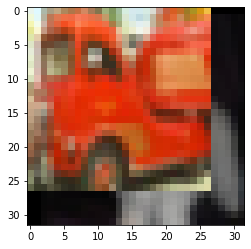

tensor([[2.8740e-05, 1.4232e-05, 9.9974e-01, 3.7711e-05, 3.6874e-05, 3.9583e-05,
         2.2302e-05, 4.6551e-05, 2.4903e-05, 7.3148e-06]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.0000, 0.8473, 0.0000, 0.1527, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
(tensor(4), 2) tensor(0.9997, grad_fn=<SelectBackward>) tensor(0.0668)


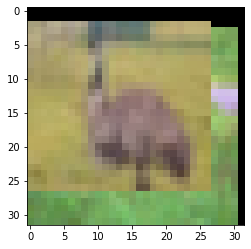

tensor([[1.2371e-04, 6.0362e-05, 9.2245e-05, 3.2307e-04, 1.0703e-04, 9.9905e-01,
         3.8915e-05, 9.1275e-05, 7.7279e-05, 3.2923e-05]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.0000, 0.0000, 0.1009, 0.0000, 0.8991, 0.0000, 0.0000, 0.0000,
        0.0000])
(tensor(3), 5) tensor(0.9991, grad_fn=<SelectBackward>) tensor(0.0552)


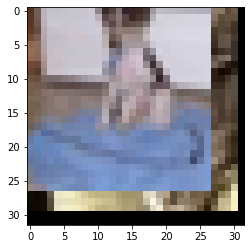

tensor([[3.6810e-05, 5.4228e-05, 1.4602e-04, 2.7098e-04, 8.2268e-05, 9.9910e-01,
         5.3869e-05, 1.7790e-04, 2.6817e-05, 5.2739e-05]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.2031, 0.0000, 0.0000, 0.0000, 0.7969, 0.0000, 0.0000, 0.0000,
        0.0000])
(tensor(1), 5) tensor(0.9991, grad_fn=<SelectBackward>) tensor(0.0552)


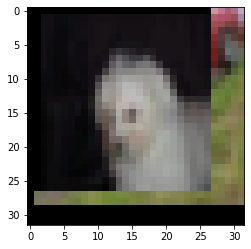

tensor([[2.0170e-05, 1.3937e-05, 7.4728e-05, 3.5065e-05, 9.9969e-01, 4.5336e-05,
         3.9381e-05, 4.9906e-05, 1.6013e-05, 1.4624e-05]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.0000, 0.0413, 0.0000, 0.9587, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
(tensor(2), 4) tensor(0.9997, grad_fn=<SelectBackward>) tensor(0.0619)


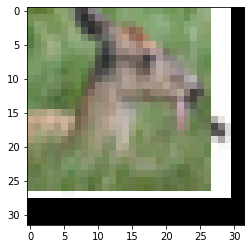

tensor([[3.8616e-04, 4.5123e-05, 1.3463e-04, 8.3922e-05, 9.9871e-01, 2.0022e-04,
         5.5379e-05, 2.3393e-04, 8.7095e-05, 6.7684e-05]],
       grad_fn=<SoftmaxBackward>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
(tensor(4), 4) tensor(0.9987, grad_fn=<SelectBackward>) tensor(0.0619)


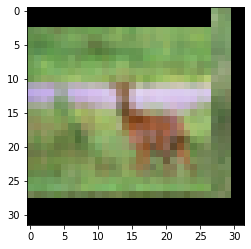

tensor([[4.2843e-04, 9.9104e-01, 5.9655e-03, 7.2411e-05, 2.8434e-04, 1.1802e-04,
         1.2587e-04, 1.6976e-04, 3.2136e-04, 1.4695e-03]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.8353, 0.1647, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
(tensor(2), 1) tensor(0.9910, grad_fn=<SelectBackward>) tensor(0.0601)


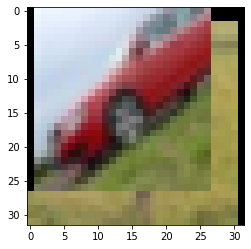

tensor([[5.9150e-04, 9.1833e-04, 6.5363e-03, 7.2737e-01, 3.6674e-03, 1.6517e-03,
         2.5575e-01, 1.2922e-03, 9.4218e-04, 1.2808e-03]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.0000, 0.0000, 0.8172, 0.0000, 0.1828, 0.0000, 0.0000, 0.0000,
        0.0000])
(tensor(5), 3) tensor(0.7274, grad_fn=<SelectBackward>) tensor(0.0633)


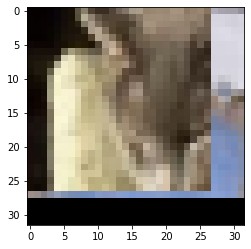

tensor([[9.1057e-04, 3.9615e-04, 1.8483e-03, 3.5922e-03, 1.2651e-03, 4.0917e-04,
         9.8798e-01, 5.3126e-04, 7.3219e-04, 2.3373e-03]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8447, 0.0000, 0.0000,
        0.1553])
(tensor(9), 6) tensor(0.9880, grad_fn=<SelectBackward>) tensor(0.0553)


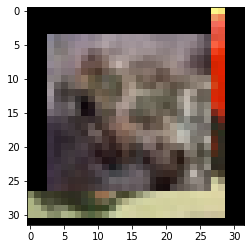

tensor([[1.4796e-04, 2.9207e-05, 9.9923e-01, 8.2356e-05, 1.4810e-04, 4.5206e-05,
         6.2210e-05, 7.3464e-05, 7.4280e-05, 1.1151e-04]],
       grad_fn=<SoftmaxBackward>)
tensor([0.0000, 0.0000, 0.7615, 0.0000, 0.0000, 0.0000, 0.2385, 0.0000, 0.0000,
        0.0000])
(tensor(6), 2) tensor(0.9992, grad_fn=<SelectBackward>) tensor(0.0668)


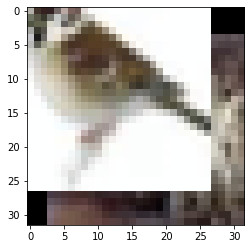

In [157]:


for i,im in enumerate(ag):
    target = torch.nn.Softmax(dim=1)(t_net(im.unsqueeze(0)))
    category = np.argmax(target.cpu().data.numpy())
    print(target)
    print(agy[i].detach())
    print((Y[i],category),target[0][category],target1[0][category])
    plot_timage(im.detach())


tensor([ 0,  2, 32])

torch.Size([10, 3, 32, 32])

In [550]:
grad=torch.rand(3,3,32,32)

In [586]:
mx=grad.view(3,-1).max(dim=1)[0]
mx

tensor([0.9998, 1.0000, 0.9994])

In [558]:
me=grad.view(3,-1).mean(dim=1)
me

tensor([0.4976, 0.5028, 0.5061])

In [584]:
mx/me

tensor([2.0093, 1.9887, 1.9746])

In [605]:
from numpy.random import beta


0.6661058811951459


In [750]:
for i,j  in enumerate([1,2,3]):
    print(i,j)

0 1
1 2
2 3


In [635]:
one_hot(torch.tensor([2,5]),10)

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])